In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import collections
import urllib2
from bs4 import BeautifulSoup 
import string
import re
from bs4 import NavigableString
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
def buildSlangDictionary():
    alpha = list(map(chr, range(ord('a'), ord('z')+1)))
    url = 'http://www.noslang.com/dictionary/'
    headers = {
        'User-Agent': "Mozilla/5.0 (Windows NT 6.1; Win64; x64)",
        'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        'Accept-Language': "de,en-US;q=0.7,en;q=0.3",
        'Accept-Charset': "ISO-8859-1,utf-8;q=0.7,*;q=0.3",
        'Accept-Encoding': 'none',
        'Connection': "keep-alive"
    }
    slang_dict = collections.defaultdict(str)
    for letter in alpha:
        url = url + letter + '/'
        req = urllib2.Request(url, headers=headers)
        response = urllib2.urlopen(req)
        soup = BeautifulSoup(response)
        abbr_list = []
        for abbr in soup.findAll('abbr'):
            abbr_list.append(abbr)
        for x in abbr_list:
            temp = x.contents[0].contents[0].contents
            if isinstance(temp[0], NavigableString):
                slang = ''.join(temp)
                slang = slang.encode('ascii', 'ignore')
                slang = slang.split(' :')[0]
                meaning = x['title']
                slang_dict[slang] = meaning
        url = url[:-2]
    return slang_dict

In [3]:
def clean_tweet(tweet, slang_dict):
    #remove urls
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'pic.twitter\S+', '', tweet)
    
    #remove hashtags and mentions
    #tweet = re.sub(r'#\S+', '', tweet)
    tweet = re.sub(r'@\S+', '', tweet)
    
    #Remove stop-words and punctuation
    stopset = stopwords.words('english') + list(string.punctuation)
        
    tokeniser = TweetTokenizer()
    tweet_tokens = tokeniser.tokenize(tweet.lower())
    tokens = [i for i in tweet_tokens if i not in stopset and len(i) > 2]

     
    #Stemming
    #porter_stemmer = PorterStemmer()
    #tokens = [porter_stemmer.stem(token) for token in tokens]
    
    #Lemmanisation
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    
    #Slang lookup
    tweet_tokens = []
    
    for i in range(len(tokens)):
        if tokens[i] in slang_dict:
            abbrev = slang_dict[tokens[i]].split()
            abbrev = [j for j in abbrev if j not in stopset and len(j)>2]
            tweet_tokens.extend(abbrev)
        else:
            tweet_tokens.append(tokens[i])
    del tokens

    
    
    tweet = ' '.join(tweet_tokens)
    
    return tweet

In [4]:
slang_dict = buildSlangDictionary()


/usr/lib/python2.7/dist-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [5]:
tweets = pd.read_csv('GetOldTweets-python/output_got_Dec.csv', delimiter='\t', quotechar='"')

In [6]:
text = tweets['text']
text = text.str.decode('utf-8')
text = text.str.encode('ascii', errors='ignore')

In [7]:
text_clean = text.apply(clean_tweet, args=(slang_dict,))

In [8]:
indexes = []
for i in range(len(text_clean)):
    tokens = text_clean[i].split()

    for x in tokens:
        if re.search('[a-zA-Z]', x) == None or len(str(x)) < 3:
            text_clean[i] = text_clean[i].replace(x, '')
    del tokens
    tokens = text_clean[i].split()
    if len(tokens) < 3:
        indexes.append(i)
        
    text_clean[i] = str(text_clean[i]).strip()
    text_clean[i] = re.sub(r'\s+', ' ', text_clean[i])
    del tokens
text_clean.drop(indexes, inplace=True)
del indexes

In [9]:
tweets['text'] = text_clean
tweets = tweets[pd.notnull(tweets['text'])]

## WordCloud

In [33]:
def wordcloud(tweets, words):
    text = tweets[tweets['text'].str.contains(words)]['text']
    stopset = list(STOPWORDS)
    
    stopset.extend(words.split('|'))
    stopset.extend(['demonetisation', 'demonetization'])
    wordcloud = WordCloud(background_color='white', stopwords=stopset, width=2000, height=1800).generate(" ".join(text))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

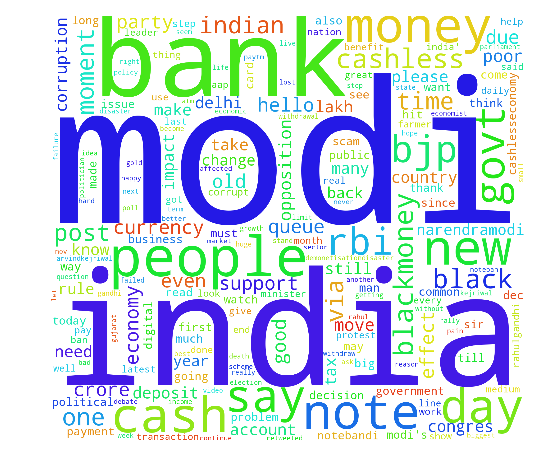

In [34]:
wordcloud(tweets, r'demonetisation|demonetization')

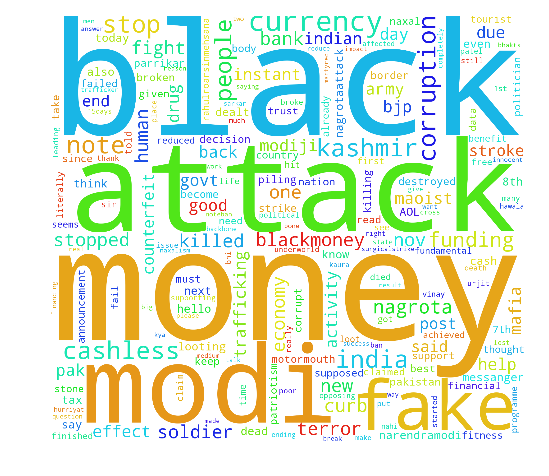

In [44]:
wordcloud(tweets, r'terrorist|terrorism|terrorists')

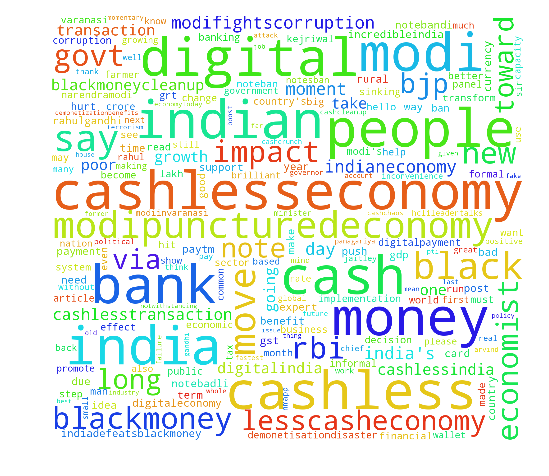

In [36]:
wordcloud(tweets, r'economy')

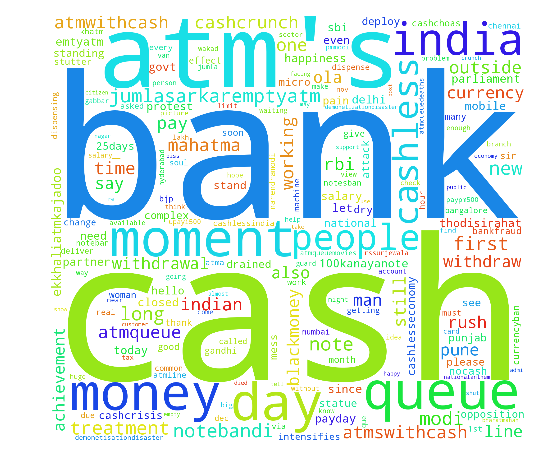

In [46]:
wordcloud(tweets, r'atm|ATM|atms')

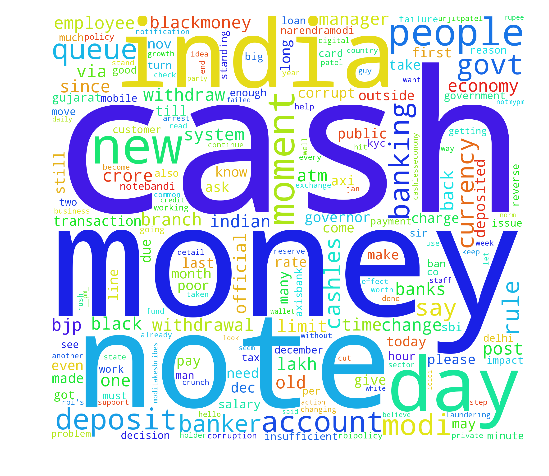

In [42]:
wordcloud(tweets,r'rbi|bank')

## Word Frequencies 

## Word Associations

## Sentiment Word Associations

In [85]:
analyzer = SentimentIntensityAnalyzer()

tweets['sentiment_compound_polarity']=tweets.text.apply(lambda x:analyzer.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text.apply(lambda x:analyzer.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text.apply(lambda x:analyzer.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text.apply(lambda x:analyzer.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

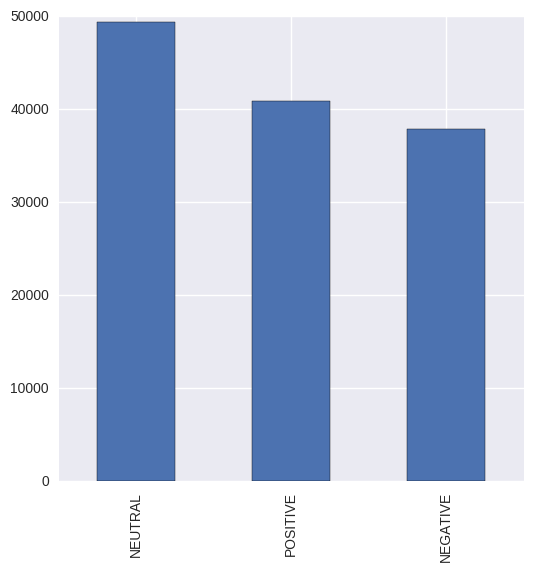

In [86]:
tweets.sentiment_type.value_counts().plot(kind='bar',title="")
plt.show()

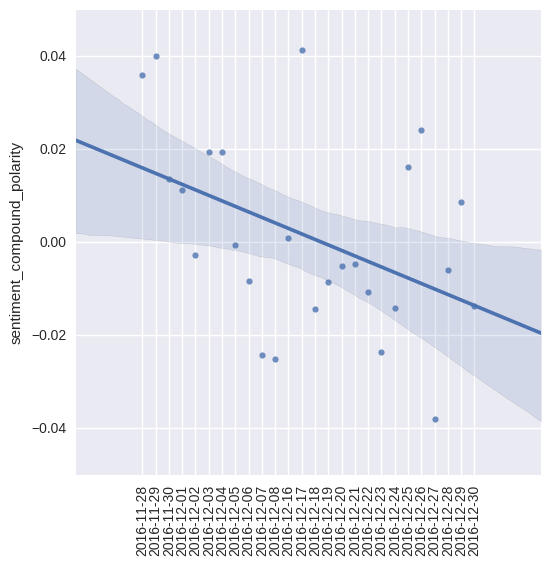

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 6.0)

tweets['hour'] = pd.DatetimeIndex(tweets['date']).hour
tweets['date'] = pd.DatetimeIndex(tweets['date']).date
tweets['minute'] = pd.DatetimeIndex(tweets['date']).minute
dt=(tweets.groupby('date',as_index=False).sentiment_compound_polarity.mean())

sns.regplot(x=np.arange(len(dt)),y=dt['sentiment_compound_polarity'])
xticks = plt.xticks(range(len(dt)), dt['date'], rotation='vertical')